In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.compose import make_column_transformer,make_column_selector
from tensorflow.keras import layers

In [2]:
RW=pd.read_csv('red-wine.csv')
RW.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [35]:
RW.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


数据集包含了11种通常被认为对红酒质量评价较为重要的参数，按照重要性排序为：
1. Alcohol（酒精度）：酒精度通常被视为红酒质量的重要指标之一，因为它能够影响口感、口腔感觉和整体平衡。2. pH值：pH值对于红酒的口感和稳定性有着重要的影响。合适的pH值能够确保酒液呈现出良好的口感和结构。
3. Total sulfur dioxide（总二氧化硫）：二氧化硫是一种防止红酒氧化和微生物污染的重要防腐剂，因此其含量对于红酒的质量和稳定性至关重要。
4. 
Residual sugar（残留糖分）：残留糖分能够影响红酒的口感和甜度水平，对于口感平衡和风味表。
5. 
Volatile acidity（挥发性酸度）：适量的挥发性酸度可以为红酒增添新鲜感和复杂性，但过高的挥发性酸度可使表现不. 
6. 。
Fixed acidity（固定酸度）：固定酸度通常与红酒的口感和结构相关，但相对于其他因素，其对于整体影响略显次要。
7. 要。
Sulphates（硫酸盐）：硫酸盐在红酒中可以起到抗氧化和防腐的作用，体影响较小。
8. 较小。
Chlorides（氯化物）：氯化物含量通常不是评价红酒质量的重要指标，况下会影响口感和风味。
9. 和风味。
Citric acid（柠檬酸）：柠檬酸的含量对红酒品>
10. 
10. 影响较小。
Free sulfur dioxide（游离二氧化硫）：游离二氧化硫的含量相对总二氧化硫而言通常影响较影响稳定性，
11.   
11. density(密度）：一般而言，在对红酒等级进相对其他参数对品质影响不大性产生一定影响。

In [18]:
features_2=['alcohol','pH']
features_4=['alcohol','pH','total sulfur dioxide','residual sugar']
features_6=['alcohol','pH','total sulfur dioxide','residual sugar','volatile acidity','fixed acidity']
features_8=['alcohol','pH','total sulfur dioxide','residual sugar','volatile acidity','fixed acidity','sulphates','chlorides']
features_11=['alcohol','pH','total sulfur dioxide','residual sugar','volatile acidity','fixed acidity','sulphates','chlorides','citric acid','free sulfur dioxide','density']

x_2=RW[features_2]
x_4=RW[features_4]
x_6=RW[features_6]
x_8=RW[features_8]
x_11=RW[features_11]
y=RW.quality

preprocessor=make_column_transformer(
    (StandardScaler(),make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object))
)
    

# 2×2

Epoch 1/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4339 - val_loss: 0.4246
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.4191 - val_loss: 0.4106
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.4049 - val_loss: 0.3970
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3916 - val_loss: 0.3841
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3791 - val_loss: 0.3716
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3668 - val_loss: 0.3592
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3548 - val_loss: 0.3472
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3431 - val_loss: 0.3355
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3317 - val_loss: 0.3241
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3207 - val_loss: 0.3129
Epoch 11

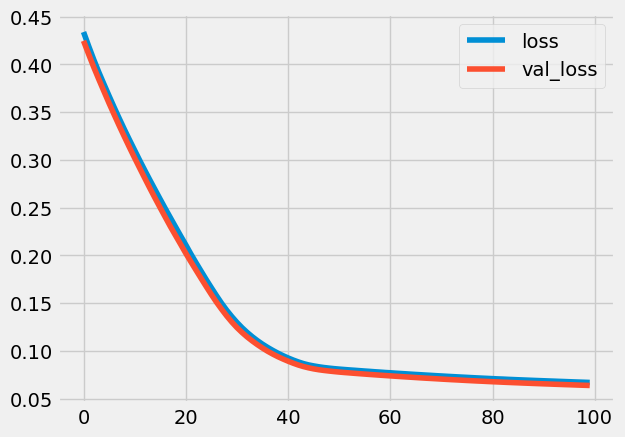

In [30]:
train_x_2,val_x_2,train_y,val_y=train_test_split(x_2,y,random_state=1)

train_x_2=preprocessor.fit_transform(train_x_2)
val_x_2=preprocessor.transform(val_x_2)
train_y=train_y/10
val_y=val_y/10

model_2=keras.Sequential([
    layers.Dense(units=2,activation='relu',input_shape=[2]),
    layers.Dense(units=2,activation='relu'),
    layers.Dense(units=1)
])
model_2.compile(
    optimizer='adam',
    loss='mae'
)
history=model_2.fit(
    train_x_2,train_y,
    validation_data=(val_x_2,val_y),
    batch_size=100,
    epochs=100,
)
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minium Validation Loss:{:0.4f}".format(history_df['val_loss'].min()))

In [31]:
model_2.weights

[<tf.Variable 'dense_27/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.25962624,  0.13080877],
        [ 0.39629924, -0.05430112]], dtype=float32)>,
 <tf.Variable 'dense_27/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.03225608, -0.42529777], dtype=float32)>,
 <tf.Variable 'dense_28/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-1.1779431 ,  0.006747  ],
        [-0.10834265, -0.41618663]], dtype=float32)>,
 <tf.Variable 'dense_28/bias:0' shape=(2,) dtype=float32, numpy=array([0.       , 0.4693053], dtype=float32)>,
 <tf.Variable 'dense_29/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.52516794],
        [ 0.31300914]], dtype=float32)>,
 <tf.Variable 'dense_29/bias:0' shape=(1,) dtype=float32, numpy=array([0.45116574], dtype=float32)>]

# 4×4

Epoch 1/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5461 - val_loss: 0.5075
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.4910 - val_loss: 0.4550
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4457 - val_loss: 0.4210
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4152 - val_loss: 0.3974
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3916 - val_loss: 0.3773
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3712 - val_loss: 0.3576
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3517 - val_loss: 0.3376
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3323 - val_loss: 0.3176
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3127 - val_loss: 0.2976
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2932 - val_loss: 0.2776
Epoch 11

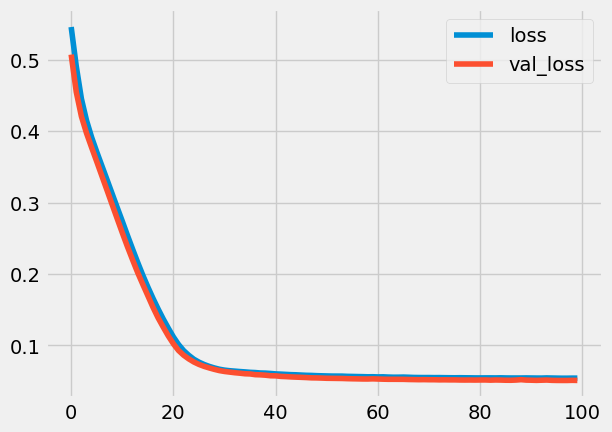

In [33]:
train_x_4,val_x_4,train_y,val_y=train_test_split(x_4,y,random_state=1)

train_x_4=preprocessor.fit_transform(train_x_4)
val_x_4=preprocessor.transform(val_x_4)
train_y=train_y/10
val_y=val_y/10

model_4=keras.Sequential([
    layers.Dense(units=4,activation='relu',input_shape=[4]),
    layers.Dense(units=4,activation='relu'),
    layers.Dense(units=1)
])
model_4.compile(
    optimizer='adam',
    loss='mae'
)
history=model_4.fit(
    train_x_4,train_y,
    validation_data=(val_x_4,val_y),
    batch_size=100,
    epochs=100,
)
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minium Validation Loss:{:0.4f}".format(history_df['val_loss'].min()))

In [36]:
model_4.weights

[<tf.Variable 'dense_30/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.81551176, -0.36788684, -0.4480646 ,  0.6454583 ],
        [ 0.06217915,  0.41016436,  0.24538386, -0.63095266],
        [ 0.3515686 ,  0.1686034 ,  0.8331463 ,  0.24900061],
        [-0.24577495, -0.21212612,  0.7403265 ,  0.6759994 ]],
       dtype=float32)>,
 <tf.Variable 'dense_30/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.38405028, -0.09137715, -0.2846429 ,  0.15794486], dtype=float32)>,
 <tf.Variable 'dense_31/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.29384595,  0.8771071 ,  0.70005167,  0.4652831 ],
        [ 0.04862803,  0.20152025, -0.9215924 ,  0.2816622 ],
        [-0.1706649 , -0.4922126 ,  0.34773174, -0.56598836],
        [ 0.29243484,  0.8346219 , -0.20779793, -0.37240344]],
       dtype=float32)>,
 <tf.Variable 'dense_31/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.32283932, -0.07649705, -0.02740545, -0.11726338], dtype=float32)>,
 <tf.Variable 'dense_32/kernel:0' 

# 6×6

Epoch 1/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6395 - val_loss: 0.5404
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5099 - val_loss: 0.4252
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4028 - val_loss: 0.3411
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3309 - val_loss: 0.2910
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2911 - val_loss: 0.2563
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2622 - val_loss: 0.2306
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2383 - val_loss: 0.2101
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2185 - val_loss: 0.1935
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2011 - val_loss: 0.1801
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1860 - val_loss: 0.1684
Epoch 11

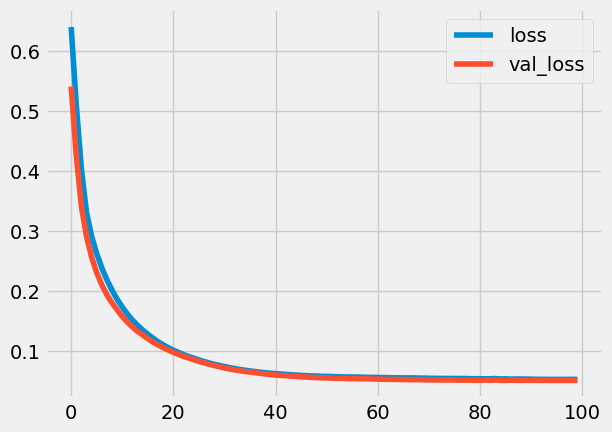

In [37]:
train_x_6,val_x_6,train_y,val_y=train_test_split(x_6,y,random_state=1)

train_x_6=preprocessor.fit_transform(train_x_6)
val_x_6=preprocessor.transform(val_x_6)
train_y=train_y/10
val_y=val_y/10

model_6=keras.Sequential([
    layers.Dense(units=6,activation='relu',input_shape=[6]),
    layers.Dense(units=6,activation='relu'),
    layers.Dense(units=1)
])
model_6.compile(
    optimizer='adam',
    loss='mae'
)
history=model_6.fit(
    train_x_6,train_y,
    validation_data=(val_x_6,val_y),
    batch_size=100,
    epochs=100,
)
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minium Validation Loss:{:0.4f}".format(history_df['val_loss'].min()))

In [38]:
model_6.weights

[<tf.Variable 'dense_33/kernel:0' shape=(6, 6) dtype=float32, numpy=
 array([[ 0.03628654, -0.3755958 ,  0.39086327, -0.1639473 , -0.13894832,
          0.05915575],
        [ 0.4800652 ,  0.6124184 , -0.4355656 , -0.2793038 ,  0.4542105 ,
         -0.5063145 ],
        [-0.33074915, -0.2963878 ,  0.01692396,  0.17962548, -0.19283834,
         -0.43133858],
        [-0.15325366, -0.49391794,  0.35233536, -0.38861364, -0.60940003,
         -0.13690846],
        [ 0.5782574 ,  0.28228956, -0.2984764 ,  0.30329585, -0.09971376,
          0.4479042 ],
        [ 0.11091666,  0.39378795, -0.3186399 , -0.5755597 ,  0.38940755,
          0.51645225]], dtype=float32)>,
 <tf.Variable 'dense_33/bias:0' shape=(6,) dtype=float32, numpy=
 array([ 0.08224928, -0.1674929 , -0.12828891,  0.19741526,  0.2793959 ,
         0.15382022], dtype=float32)>,
 <tf.Variable 'dense_34/kernel:0' shape=(6, 6) dtype=float32, numpy=
 array([[ 0.54019046,  0.25050858,  0.15043722,  0.37261552,  0.19501586,
          0

# 8×8

Epoch 1/100
12/12 [==============================] - 1s 15ms/step - loss: 0.3781 - val_loss: 0.3481
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3066 - val_loss: 0.2983
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2623 - val_loss: 0.2666
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2357 - val_loss: 0.2391
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2139 - val_loss: 0.2173
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1975 - val_loss: 0.2005
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1848 - val_loss: 0.1874
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1733 - val_loss: 0.1759
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1628 - val_loss: 0.1650
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1536 - val_loss: 0.1551
Epoch 11

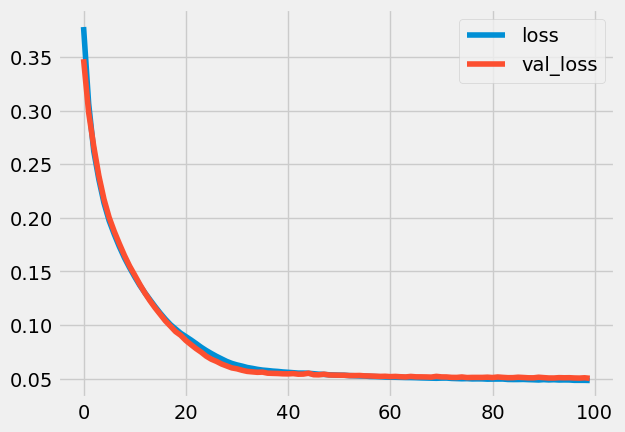

In [39]:
train_x_8,val_x_8,train_y,val_y=train_test_split(x_8,y,random_state=1)

train_x_8=preprocessor.fit_transform(train_x_8)
val_x_8=preprocessor.transform(val_x_8)
train_y=train_y/10
val_y=val_y/10

model_8=keras.Sequential([
    layers.Dense(units=8,activation='relu',input_shape=[8]),
    layers.Dense(units=8,activation='relu'),
    layers.Dense(units=1)
])
model_8.compile(
    optimizer='adam',
    loss='mae'
)
history=model_8.fit(
    train_x_8,train_y,
    validation_data=(val_x_8,val_y),
    batch_size=100,
    epochs=100,
)
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minium Validation Loss:{:0.4f}".format(history_df['val_loss'].min()))

In [40]:
model_8.weights

[<tf.Variable 'dense_36/kernel:0' shape=(8, 8) dtype=float32, numpy=
 array([[ 0.522134  , -0.08405911, -0.11815623,  0.2010062 ,  0.06231811,
         -0.2430617 , -0.01717284, -0.12023252],
        [ 0.32860148,  0.44914177, -0.22486104, -0.36046547, -0.43063387,
         -0.17572054,  0.3890962 , -0.22740594],
        [-0.07444493, -0.36142853, -0.08725451, -0.36923862,  0.39596045,
          0.15198778, -0.2849755 ,  0.53407085],
        [-0.08107117,  0.22170353, -0.32690057, -0.21753542,  0.24486925,
         -0.15785363, -0.5042429 ,  0.00527237],
        [ 0.21491307,  0.39646676, -0.32849693, -0.43392584, -0.36145094,
         -0.06608254, -0.39241427, -0.20007339],
        [-0.24154428,  0.51929617, -0.31362894, -0.27537116,  0.24774978,
         -0.21524647, -0.17180909,  0.11235359],
        [ 0.1227858 , -0.3980287 ,  0.37593803,  0.4057204 , -0.31842402,
          0.05505809,  0.48995063, -0.5989608 ],
        [-0.3272848 ,  0.4820116 , -0.3788716 ,  0.10566313, -0.534015

# 11×11

Epoch 1/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8315 - val_loss: 0.7123
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6739 - val_loss: 0.5738
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5303 - val_loss: 0.4515
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.4097 - val_loss: 0.3529
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3199 - val_loss: 0.2790
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2500 - val_loss: 0.2267
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2093 - val_loss: 0.1960
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1850 - val_loss: 0.1769
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1671 - val_loss: 0.1612
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1518 - val_loss: 0.1492
Epoch 11

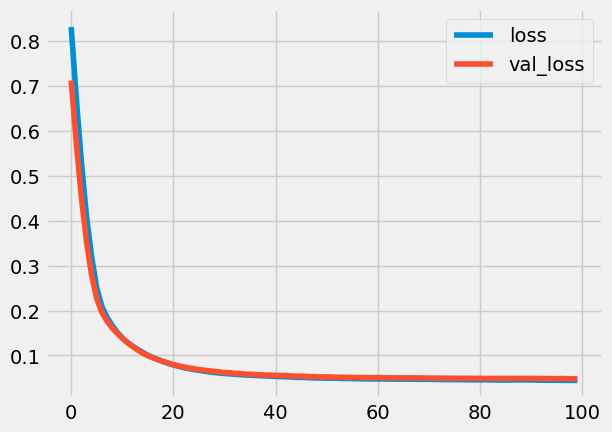

In [41]:
train_x_11,val_x_11,train_y,val_y=train_test_split(x_11,y,random_state=1)

train_x_11=preprocessor.fit_transform(train_x_11)
val_x_11=preprocessor.transform(val_x_11)
train_y=train_y/10
val_y=val_y/10

model_11=keras.Sequential([
    layers.Dense(units=11,activation='relu',input_shape=[11]),
    layers.Dense(units=11,activation='relu'),
    layers.Dense(units=1)
])
model_11.compile(
    optimizer='adam',
    loss='mae'
)
history=model_11.fit(
    train_x_11,train_y,
    validation_data=(val_x_11,val_y),
    batch_size=100,
    epochs=100,
)
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minium Validation Loss:{:0.4f}".format(history_df['val_loss'].min()))

In [42]:
model_11.weights

[<tf.Variable 'dense_39/kernel:0' shape=(11, 11) dtype=float32, numpy=
 array([[ 0.34488514,  0.22976464,  0.36126208,  0.39189988,  0.3706495 ,
         -0.08084574, -0.02420585, -0.17805268,  0.33659637, -0.32364368,
         -0.45674065],
        [ 0.12357853,  0.00904791,  0.10343555, -0.17799987, -0.14794485,
         -0.04343391, -0.13347769, -0.39478225,  0.10354532,  0.44227397,
         -0.16558996],
        [-0.18442503, -0.34122446, -0.19835514, -0.28150773,  0.12447057,
          0.00477565,  0.17088215,  0.12353803, -0.5336097 , -0.36156115,
          0.3215793 ],
        [-0.38049728, -0.02740431, -0.39116305,  0.29512998,  0.10653398,
         -0.18312363, -0.16713408, -0.05602416,  0.2815346 , -0.06094148,
          0.11766488],
        [ 0.03198615,  0.01172379, -0.07663154,  0.20992239, -0.10391478,
          0.28870723,  0.03689799,  0.28682187, -0.45068273, -0.20158762,
         -0.06844196],
        [ 0.15648468, -0.3716445 , -0.10826107,  0.16230026, -0.00378435,
